In [23]:
import os, argparse, json, re
from collections import defaultdict
import customutils
import pandas as pd
import numpy as np

LABELS = customutils.get_classes('configs/halpe26_classes.txt')
LABELS_COCOWB = customutils.get_classes('configs/cocowb_classes.txt')
LABELS_COCO = customutils.get_classes('configs/coco_classes.txt')
LABELS_FOOT = ['LBigToe','RBigToe','LSmallToe','RSmallToe','LHeel','RHeel']
LABELS_MISSING = ['Head','Neck','Hip']

df_running_annotations = customutils.load_images_dataframe()

In [24]:
lst_filenames = [
    'World_Athletics_Women_5000m_Oregon_2022_28.mp4' 
]

In [25]:
df_lat = df_running_annotations[(df_running_annotations['file_name'].isin(lst_filenames))]['image_id']
df_lat

10871    42000
10872    42001
10873    42002
10874    42003
10875    42004
         ...  
11004    42064
11005    42065
11006    42066
11007    42067
11008    42068
Name: image_id, Length: 138, dtype: int64

Initialize dataframe

In [26]:
df = customutils.load_keypoints_dataframe()
df[df.duplicated(subset=['id'],keep=False)]
df = df.drop(columns=['iscrowd', 'num_keypoints'])
df = df.set_index(['id'])

df_categories = customutils.load_categories_dataframe()
kpts_classes = df_categories[df_categories['id'] == 1]['keypoints'][0]

df['kpts_alphapose'] = ""
df['kpts_vitpose'] = ""
df['kpts_cotracker'] = ""
df['kpts_cotracker2'] = ""
df['kpts_cotracker3'] = ""
df['dist_vitpose'] = np.ones((len(df),1)) * np.inf
df['dist_alphapose'] = np.ones((len(df),1)) * np.inf
df['dist_cotracker'] = np.ones((len(df),1)) * np.inf
df['dist_cotracker2'] = np.ones((len(df),1)) * np.inf
df['dist_cotracker3'] = np.ones((len(df),1)) * np.inf
df['oks_alphapose'] = float(0.0)
df['oks_cotracker'] = float(0.0)
df['oks_cotracker2'] = float(0.0)
df['oks_cotracker3'] = float(0.0)
df['oks_coco_alphapose'] = float(0.0)
df['oks_coco_vitpose'] = float(0.0)
df['oks_coco_cotracker'] = float(0.0)
df['oks_coco_cotracker2'] = float(0.0)
df['oks_coco_cotracker3'] = float(0.0)
df['oks_foot_alphapose'] = float(0.0)
df['oks_foot_vitpose'] = float(0.0)
df['oks_foot_cotracker'] = float(0.0)
df['oks_foot_cotracker2'] = float(0.0)
df['oks_foot_cotracker3'] = float(0.0)
df['alphapose_idx'] = ""
df['cotracker_idx'] = ""
df['head_size'] = ""
df['pckh_alphapose'] = ""
df['pckh_vitpose'] = ""
df['pckh_cotracker'] = ""
df['pckh_cotracker2'] = ""
df['pckh_cotracker3'] = ""
df

,image_id,idx,category_id,bbox,bbox_head,area,keypoints,kpts_alphapose,kpts_vitpose,kpts_cotracker,...,oks_foot_cotracker2,oks_foot_cotracker3,alphapose_idx,cotracker_idx,head_size,pckh_alphapose,pckh_vitpose,pckh_cotracker,pckh_cotracker2,pckh_cotracker3
id,,,,,,,,,,,,,,,,,,,,,
1000,1000,0,1,"[957.5031, 204.6478, 294.4987, 641.9175]","[0, 0, 0, 0]",189043.869257,"[1132.7201, 271.7583, 2, 1151.8834, 256.5806, ...",,,,...,0.0,0.0,,,,,,,,
1001,1001,0,1,"[895.2875, 201.4572, 396.59609999999986, 639.6...","[0, 0, 0, 0]",253699.828317,"[1135.4403, 262.4473, 2, 1151.8834, 253.39, 2,...",,,,...,0.0,0.0,,,,,,,,
1002,1002,0,1,"[876.5417, 207.8383, 455.8919000000001, 641.2885]","[0, 0, 0, 0]",292358.232713,"[1132.7201, 255.8056, 2, 1148.6928, 247.0089, ...",,,,...,0.0,0.0,,,,,,,,
1003,1003,0,1,"[892.6316, 187.0998, 445.91919999999993, 658.8...","[0, 0, 0, 0]",293787.800419,"[1129.5295, 249.4245, 2, 1145.5023, 240.6278, ...",,,,...,0.0,0.0,,,,,,,,
1004,1004,0,1,"[912.8355, 201.4572, 406.572, 681.1703]","[0, 0, 0, 0]",276944.771212,"[1132.7201, 249.4245, 2, 1148.6928, 240.6278, ...",,,,...,0.0,0.0,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145160,45160,1,1,"[749.0932, 271.5931, 241.01109999999994, 816.5...","[784.0, 225.0, 96.0, 141.0]",196795.299998,"[811.8716, 319.3694, 2, 827.6156, 303.8024, 2,...",,,,...,0.0,0.0,,,,,,,,
145161,45161,1,1,"[749.0932, 271.5931, 241.01109999999994, 816.5...","[784.0, 225.0, 96.0, 141.0]",196795.299998,"[811.8716, 319.3694, 2, 827.6156, 303.8024, 2,...",,,,...,0.0,0.0,,,,,,,,
145162,45162,1,1,"[749.0932, 271.5931, 241.01109999999994, 816.5...","[784.0, 225.0, 96.0, 141.0]",196795.299998,"[811.8716, 319.3694, 2, 827.6156, 303.8024, 2,...",,,,...,0.0,0.0,,,,,,,,


In [5]:
def eval_PCKh(id, keypoint_visible_array, gt_keypoints_array, eval_keypoints_array, eval_keypoint_visible_array, headsize, threshold=0.5):
    
    eval_keypoint_visible_array = np.array(eval_keypoint_visible_array)
    eval_keypoint_visible_array = eval_keypoint_visible_array - np.ones(len(eval_keypoint_visible_array))
    #eval_keypoint_visible_array = np.multiply(eval_keypoints_array, eval_keypoint_visible_array)
    eval_keypoints_array = eval_keypoints_array * eval_keypoint_visible_array[:, np.newaxis]

    # keypoints error
    keypoints_error = eval_keypoints_array - gt_keypoints_array
    keypoints_error = np.linalg.norm(keypoints_error, axis=1)

    # normalized head size
    # headsizes = headboxes_array[1, :, :] - headboxes_array[0, :, :]
    # headsizes = np.linalg.norm(headsizes, axis=0)
    # headsizes *= HEAD_SCALE_BIAS
    
    keypoint_visible_array = np.array(keypoint_visible_array)
    keypoint_visible_array = keypoint_visible_array - np.ones(len(keypoint_visible_array))


    # scaled keypoints error with head size
    scale = np.multiply(headsize, np.ones(len(keypoints_error)))
    scaled_keypoints_error = np.divide(keypoints_error, scale)
    scaled_keypoints_error = np.multiply(scaled_keypoints_error, keypoint_visible_array)

    # calculate PCKh@threshold score
    keypoint_count = len(keypoint_visible_array)
    PCKh = np.multiply((scaled_keypoints_error < threshold), keypoint_visible_array)
    # PCKh = np.divide(100. * np.sum(less_than_threshold, axis=1), keypoint_count)
    # PCKh = np.divide(100. * less_than_threshold, keypoint_count)

    # PCKh = np.ma.array(PCKh, mask=False)
    #PCKh.mask[6:8] = True


    # get index of keypoints
    # head_top = kpts_classes.index('head')
    # left_shoulder = kpts_classes.index('left_shoulder')
    # left_elbow = kpts_classes.index('left_elbow')
    # left_wrist = kpts_classes.index('left_wrist')
    # left_hip = kpts_classes.index('left_hip')
    # left_knee = kpts_classes.index('left_knee')
    # left_ankle = kpts_classes.index('left_ankle')
    # left_heel = kpts_classes.index('left_heel')
    # left_big_toe = kpts_classes.index('left_big_toe')
    # left_small_toe = kpts_classes.index('left_small_toe')

    # right_shoulder = kpts_classes.index('right_shoulder')
    # right_elbow = kpts_classes.index('right_elbow')
    # right_wrist = kpts_classes.index('right_wrist')
    # right_hip = kpts_classes.index('right_hip')
    # right_knee = kpts_classes.index('right_knee')
    # right_ankle = kpts_classes.index('right_ankle')
    # right_heel = kpts_classes.index('right_heel')
    # right_big_toe = kpts_classes.index('right_big_toe')
    # right_small_toe = kpts_classes.index('right_small_toe')

    # form PCKh metric dict
    # pckh_dict = {}
    # pckh_dict['Head'] = round(PCKh[head_top], 2)
    # pckh_dict['Shoulder'] = round(0.5 * (PCKh[left_shoulder] + PCKh[right_shoulder]), 2)
    # pckh_dict['Elbow'] = round(0.5 * (PCKh[left_elbow] + PCKh[right_elbow]), 2)
    # pckh_dict['Wrist'] = round(0.5 * (PCKh[left_wrist] + PCKh[right_wrist]), 2)
    # pckh_dict['Hip'] = round(0.5 * (PCKh[left_hip] + PCKh[right_hip]), 2)
    # pckh_dict['Knee'] = round(0.5 * (PCKh[left_knee] + PCKh[right_knee]), 2)
    # pckh_dict['Ankle'] = round(0.5 * (PCKh[left_ankle] + PCKh[right_ankle]), 2)
    # pckh_dict['Heel'] = round(0.5 * (PCKh[left_heel] + PCKh[right_heel]), 2)
    # pckh_dict['Toes'] = round(0.25 * (PCKh[left_big_toe] + PCKh[left_small_toe] + PCKh[right_small_toe] + PCKh[right_big_toe]), 2)
    # mean = np.mean(PCKh)

    # if (mean < 100):
    #     # show PCKh metric
    #     print("PCKh evaluation: Head, Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, Mean (" + str(id) + ")")
    #     print('{:.2f} {:.2f}  {:.2f}  {:.2f} {:.2f}  {:.2f}  {:.2f} {:.2f}'.format(pckh_dict['Head'],
    #                                                                             pckh_dict['Shoulder'],
    #                                                                             pckh_dict['Elbow'],
    #                                                                             pckh_dict['Wrist'],
    #                                                                             pckh_dict['Hip'],
    #                                                                             pckh_dict['Knee'],
    #                                                                             pckh_dict['Ankle'],
    #                                                                             pckh_dict['Heel'],
    #                                                                             pckh_dict['Toes'],
    #                                                                             mean))
        
    return PCKh
    

In [6]:
def edit_keypoints(kpts):
    kpts = np.array(kpts).reshape(-1,3).astype(float)
    vi = kpts[:,2]
    kpts = kpts[:,0:2]
    return kpts, vi

def get_keypoint(kpts, id):
    index = kpts_classes.index(id)
    return [kpts[index*3],kpts[(index*3)+1],kpts[(index*3)+2]]

def load_keypoints(root, model):
    dist = 'dist_' + str.lower(model)
    dist_joints = 'dist_joints_' + str.lower(model)
    kpts = 'kpts_' + str.lower(model)
    pck = 'pck_' + str.lower(model)
    oks = 'oks_' + str.lower(model)
    oks_coco = 'oks_coco_' + str.lower(model)
    oks_foot = 'oks_foot_' + str.lower(model)
    file = os.path.join(root, model, 'person_keypoints_running.json')
    with open(file, 'r') as f:
        predictions = json.load(f)
        d = {}
        
        empty_keypoint = [0, 0, 0]        

        for prediction in predictions:

            # if prediction['image_id'] not in df_running_annotations['image_id'][(df_running_annotations['file_name'].isin(lst_filenames))].values:
                # continue
            idx = -1
            mask_frame = df['image_id'] == prediction['image_id']
            gts = df[mask_frame]
            dt = prediction['keypoints']
            # check if we have missing joints (compared to GT)
            if len(dt) < len(LABELS)*3:
                i = 0
                for label in LABELS:
                    if label not in LABELS_COCOWB:
                        dt[i:i] = empty_keypoint
                    i += 3

            kpts1, vi1 = edit_keypoints(dt)
            min_dist = np.inf #np.ones((len(kpts1),1)) * 
            
            # for i in range(len(gts)):
            for pose_id in gts.index:

                gt = gts['keypoints'][pose_id]
                bbox_head = gts['bbox_head'][pose_id]
                kpts2, vi2 = edit_keypoints(gt)
                d = np.linalg.norm(kpts1 - kpts2, ord=2, axis=1)
                v = np.ones(len(d))

                for part in range(len(d)):
                    if vi1[part] == 0 or vi2[part] == 0:
                        d[part] = 0
                        v[part] = 0
                                        
                area = customutils.compute_area_keypoints(gt)

                # compute head size for distance normalization
                head = get_keypoint(gt,"head")
                neck = get_keypoint(gt,"neck")

                headSize = 1
                if bbox_head[2] > 0:
                    headSize = 0.6 * np.sqrt(bbox_head[2]**2 + bbox_head[3]**2) #0.6*bbox_head[2]*bbox_head[3]
                elif (len(head) > 0 and len(neck) > 0):
                    headSize = customutils.get_head_size(head[0], head[1], neck[0], neck[1])
                # normalize distance
                dNorm = np.sum(d)/headSize

                oks_val = customutils.OKS(gt, dt, area, 0, 26)
                oks_val_coco = customutils.OKS(gt, dt, area, 0, 17)
                oks_val_foot = customutils.OKS(gt, dt, area, 20, 26)
                pckh = eval_PCKh(pose_id, vi2, kpts2, kpts1, vi1, headSize)
                pckh_mean = np.mean(pckh)

                if dNorm < min_dist and dNorm <= gts[dist][pose_id]:

                    min_dist = dNorm
                    min_dist_joints = d/headSize
                    df.loc[pose_id, dist] = min_dist
                    df.loc[pose_id, dist_joints] = ','.join(str(element) for element in min_dist_joints)
                    df.loc[pose_id, 'head_size'] = headSize
                    df.loc[pose_id, pck] = ','.join(str(element) for element in pckh)
                    df.loc[pose_id, kpts] = ','.join(str(element) for element in dt)
                    df.loc[pose_id, oks] = oks_val
                    df.loc[pose_id, oks_coco] = oks_val_coco
                    df.loc[pose_id, oks_foot] = oks_val_foot
                    if 'idx' in prediction:
                        if model == 'alphapose':
                            df.loc[pose_id, 'alphapose_idx'] = prediction['idx']
                        else:
                            for pose_id2 in gts.index:
                                if pose_id != pose_id2 and df.loc[pose_id2, 'cotracker_idx'] == prediction['idx'] and df.loc[pose_id, dist] < df.loc[pose_id2, dist]:
                                    df.loc[pose_id2, 'cotracker_idx'] = -1
                            df.loc[pose_id, 'cotracker_idx'] = prediction['idx']

                           
        # for pose_id in df.index:
        #     frame = df['image_id'][pose_id] % 1000
        #     image_no_frame = prediction['image_id'] - frame
        #     if frame != 0:
        #         first_frame = df[(df['image_id'] == image_no_frame) & (df['idx'] == df['idx'][pose_id])]
        #         #check if id matches
        #         if prediction['idx'] != first_frame.iloc[0]['alphapose_idx']:
        #             # IDSW
        #             if prediction['image_id'] in idsw_dict :
        #                 idsw_dict[prediction['image_id']] = idsw_dict[prediction['image_id']] + 1
        #             else:
        #                 idsw_dict[prediction['image_id']] = 1
        #             continue

    # print(idsw_dict)
        # df_running_annotations['score_' + str.lower(model)] = df_running_annotations['image_id'].map(d)

In [27]:
root = '../videos/results/'
# load_keypoints(root, 'ViTPose')
load_keypoints(root, 'alphapose')

In [28]:
root = '../data/videos/results/'
load_keypoints(root, 'cotracker3')

In [29]:
root = '../data/videos/results/'
load_keypoints(root, 'cotracker2')

In [ ]:
root = '../data/videos/results/'
load_keypoints(root, 'cotracker')

In [8]:
def computeAP(oks, df, thresh):
    T = len(df[df['idx'] != '-1'])
    idxs = np.argwhere((df[oks] >= thresh) & (df['idx'] != '-1'))
    ap = 100.0*len(idxs)/T
    return ap

def computeAllAP(oks, df):
    distThresh = 0.5
    ap50 = computeAP(oks, df, distThresh)
    ap = np.copy(ap50)
    for i in range(9):
        distThresh += 0.05
        ap += computeAP(oks, df, distThresh)
    ap75 = computeAP(oks, df, 0.75)
    ap = ap/10
    print('AP (' + oks + '): ' + str(ap))
    #print('AP0.5 (' + oks + '): ' + str(ap50))
    #print('AP0.75 (' + oks + '): ' + str(ap75))


In [ ]:

computeAllAP('oks_alphapose', df)
computeAllAP('oks_coco_alphapose', df)
computeAllAP('oks_foot_alphapose', df)

AP (oks_alphapose): 54.46325350949627
AP (oks_coco_alphapose): 60.34269199009084
AP (oks_foot_alphapose): 48.03385631709331


In [33]:
computeAllAP('oks_vitpose', df)
computeAllAP('oks_coco_vitpose', df)
computeAllAP('oks_foot_vitpose', df)

AP (oks_vitpose): 67.93724194880265
AP (oks_coco_vitpose): 70.16019818331957
AP (oks_foot_vitpose): 64.4987613542527


In [ ]:

computeAllAP('oks_cotracker', df)
computeAllAP('oks_coco_cotracker', df)
computeAllAP('oks_foot_cotracker', df)
computeAllAP('oks_cotracker2', df)
computeAllAP('oks_coco_cotracker2', df)
computeAllAP('oks_foot_cotracker2', df)
computeAllAP('oks_cotracker3', df)
computeAllAP('oks_coco_cotracker3', df)
computeAllAP('oks_foot_cotracker3', df)

AP (oks_cotracker): 28.820809248554912
AP (oks_coco_cotracker): 32.95540875309661
AP (oks_foot_cotracker): 23.267547481420312
AP (oks_cotracker2): 5.731626754748142
AP (oks_coco_cotracker2): 11.935590421139555
AP (oks_foot_cotracker2): 3.487200660611066
AP (oks_cotracker3): 35.52353426919902
AP (oks_coco_cotracker3): 38.77621800165153
AP (oks_foot_cotracker3): 32.14368290668869


In [ ]:

def computeAllAP_file(file, idx, oks, df, all = 0):
    distThresh = 0.5
    ap50 = computeAP(oks, df, distThresh)
    ap = np.copy(ap50)
    for i in range(9):
        distThresh += 0.05
        ap += computeAP(oks, df, distThresh)
    ap = ap/10
    field = oks.replace('oks_','').replace('_',',')
    if all == 1:
        field = 'all,' + field
    print(field + ',' + file + ',' + str(idx) + ',' + str(ap))
    

def compute_mot(model):
    #lst_filenames = df_running_annotations['file_name'].unique()
    idsw_dict = defaultdict(list)
    fails = defaultdict(list)
    gts = 0

    # fn_default = np.ones((len(kpts1),1))
    for filename in lst_filenames:
        if filename.startswith('World'):
            df_lat = df_running_annotations[df_running_annotations['file_name'] == filename]['image_id']
            df_video = df[(df['image_id'].isin(df_lat))]
            lst_idx = df_video['idx'].unique()
            for idx in lst_idx:
                df_subset = df_video[df_video['idx'] == idx]
                
                for frame_id in df_subset.index:
                    image_id = df_subset['image_id'][frame_id]
                    frame_number = image_id % 1000
                    #df_subset[df_subset['pck_alphapose'][frame_id] > 0] = 1
                    if df_subset['pck_' + model][frame_id] is not None:
                        # calculate FN and FP per joint
                        kpts2, vi2 = edit_keypoints(df_subset['keypoints'][frame_id])
                        vi2 = vi2 - np.ones(len(vi2))
                        
                        pckh = df_subset['pck_' + model][frame_id]
                        pckh = np.array(pckh.split(',')).astype(float)
                        fn_mask = (pckh == 0) & (vi2 == 1)
                        fp_mask = (pckh == 1) & (vi2 == 0)

                        fp = np.sum(fp_mask)
                        fn = np.sum(fn_mask)
                        gts += np.sum(vi2)
                        
                        if image_id in fails:
                            fails[image_id] = fails[image_id] + fp + fn
                        else:
                            fails[image_id] = fp + fn
                        
                    if frame_number != 0:
                        prev_frame = df_subset[df_subset['image_id'] == image_id-1]
                        if prev_frame.iloc[0]['alphapose_idx'] != df_subset['alphapose_idx'][frame_id]:
                            # IDSW
                            if image_id in idsw_dict :
                                idsw_dict[image_id] = idsw_dict[image_id] + 1
                            else:
                                idsw_dict[image_id] = 1
                            continue
    
    mota_top = 0
    for val, image_id in enumerate(fails):
        mota_top += val
        if image_id in idsw_dict:
            mota_top += idsw_dict[image_id]

    mota = 1-np.divide(mota_top, gts)
    print(model + ' MOTA ' + str (mota))

compute_mot('alphapose')
compute_mot('cotracker')
compute_mot('cotracker2')
compute_mot('cotracker3')
    

0.8541053320248609


In [ ]:

        # computeAllAP_file(filename, idx, 'oks_vitpose', df_subset, 1)
        # computeAllAP_file(filename, idx, 'oks_coco_vitpose', df_subset)
        # computeAllAP_file(filename, idx, 'oks_foot_vitpose', df_subset)
        # computeAllAP_file(filename, idx, 'oks_cotracker', df_subset, 1)
        # computeAllAP_file(filename, idx, 'oks_coco_cotracker', df_subset)
        # computeAllAP_file(filename, idx, 'oks_foot_cotracker', df_subset)
        # computeAllAP_file(filename, idx, 'oks_cotracker2', df_subset, 1)
        # computeAllAP_file(filename, idx, 'oks_coco_cotracker2', df_subset)
        # computeAllAP_file(filename, idx, 'oks_foot_cotracker2', df_subset)
        # computeAllAP_file(filename, idx, 'oks_cotracker3', df_subset, 1)
        # computeAllAP_file(filename, idx, 'oks_coco_cotracker3', df_subset)
        # computeAllAP_file(filename, idx, 'oks_foot_cotracker3', df_subset)

In [ ]:
pd.set_option('display.max_rows', None)

# get frames where solution is better than original
df_good = df[(df['oks_cotracker3'] > df['oks_vitpose']) | (df['oks_foot_cotracker3'] > df['oks_foot_vitpose'])][['image_id','oks_vitpose', 'oks_cotracker3','oks_foot_vitpose','oks_foot_cotracker3']]
df_good = df[(df['oks_foot_cotracker3'] > df['oks_foot_vitpose'])][['image_id','oks_vitpose', 'oks_cotracker3','oks_foot_vitpose','oks_foot_cotracker3']]

In [80]:
#pd.set_option('display.max_rows', None)

df_video = df[(df['image_id'].isin(df_lat))]
df_video[['image_id','pck_cotracker2','pck_alphapose','alphapose_idx']]

,image_id,pck_cotracker2,pck_alphapose,alphapose_idx
id,,,,
42000,42000,"1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",3
42001,42001,"1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",3
42002,42002,"1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",3
42003,42003,"1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",3
42004,42004,"1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",3
...,...,...,...,...
142064,42064,"1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",1
142065,42065,"1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",1
142066,42066,"0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1....","1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",1


In [23]:
df_subset[(df_subset['oks_cotracker3'] < df_subset['oks_vitpose'])][['image_id','oks_vitpose', 'oks_cotracker3','oks_foot_vitpose','oks_foot_cotracker3']]

,image_id,oks_vitpose,oks_cotracker3,oks_foot_vitpose,oks_foot_cotracker3
id,,,,,
1002,1002,0.924794,0.868300,0.976162,0.797956
1003,1003,0.941594,0.862254,0.980320,0.814763
1004,1004,0.921789,0.842779,0.901227,0.756604
1006,1006,0.886801,0.721274,0.938069,0.472079
1007,1007,0.923863,0.574813,0.939754,0.353553
...,...,...,...,...,...
145156,45156,0.842943,0.814678,0.901157,0.909125
145159,45159,0.807955,0.803765,0.928922,0.909397
145160,45160,0.813465,0.809792,0.905955,0.909435


In [ ]:
pd.set_option('display.max_rows', None)

# get frames where solution is better than original
df_good = df[(df['oks_cotracker'] > df['oks_vitpose']) | (df['oks_foot_cotracker'] > df['oks_foot_alphapose'])][['image_id','oks_alphapose', 'oks_cotracker','oks_foot_alphapose','oks_foot_cotracker']]

Pelvis and lower limb kinematics experimnets

In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np
 
def getAngle(x, y, z):
    a = np.array([x[0],x[1]])
    b = np.array([y[0],y[1]])
    c = np.array([z[0],z[1]])

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine_angle))
    return angle


In [132]:
df[df['image_id']==6002]#['pckh']

,image_id,idx,category_id,bbox,bbox_head,area,keypoints,kpts_alphapose,kpts_vitpose,kpts_cotracker,...,oks_foot_vitpose,oks_foot_cotracker,oks_foot_cotracker2,oks_foot_cotracker3,alphapose_idx,cotracker_idx,head_size,pckh,dist_joints_alphapose,conf_alphapose
id,,,,,,,,,,,,,,,,,,,,,
6002,6002,0,1,"[279.5855, 261.1074, 295.1453, 808.0779000000001]","[385.0, 255.0, 94.0, 111.0]",238500.394219,"[409.4896, 326.6197, 2, 423.4181, 316.2586, 2,...","1568.71826171875,525.4481811523438,2,1563.3093...",,,...,0.0,0.0,0.0,0.0,16,,6260.4,[3.84615385 3.84615385 3.84615385 3.84615385 3...,"0.1878724028121684,0.18512031410749433,0.18888...",0.201317
106002,6002,1,1,"[710.3621, 357.3504, 240.0639, 605.1691000000001]","[768.0, 349.0, 67.0, 80.0]",145279.254305,"[792.1622, 393.1853, 2, 806.2445, 381.2005, 2,...",,,,...,0.0,0.0,0.0,0.0,,,,,nan,NaN


Knee Flexion/Extension

[124.815636  99.70661   77.49507   57.158314  50.32581   48.8785
  81.734436 109.7885   160.77336  168.69005  169.05931  156.59036
 140.1772   132.4111    74.67477   74.94848   64.37592  151.38953
 125.249435  94.7274    86.90087   59.420773  61.173267  76.328674
  94.658066  96.44569  126.86986  158.15953  175.16003  142.76222
 142.71289  135.13083   94.10567  146.30997  148.19986  148.78784
 124.29502  113.316414  71.926796  58.85989   60.697838  53.607887
  67.84174   91.73573  140.36514  143.39143  162.75266  166.90894
 155.09753  140.55603  140.11618  134.26619   95.54154  152.86389
 133.39929  132.46535  106.9995    72.41539   51.90619   66.84192
  66.71209   79.75957  102.27022  130.34702  174.2555   174.56174
 160.01694  142.0121    95.39563  156.3262   157.23735  166.48952
 156.795    139.86452   91.45477   85.734245  67.33851   54.034634]


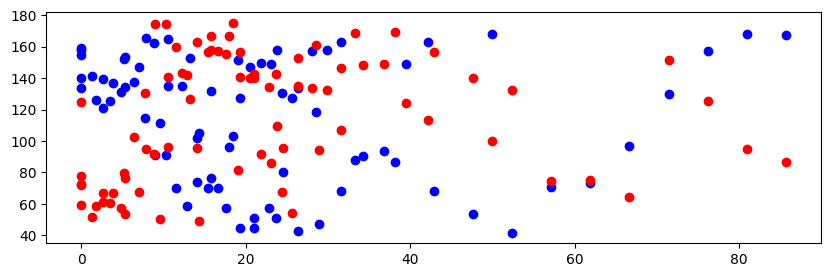

In [40]:
ic = [0,17,38,59,79]
ic = [2,21,38,57,78]
cycle = 0
xpoints1 = []
ypoints1 = []
xpoints2 = []
ypoints2 = []

for pose_id in df_test.index:
    gt = np.array(df_test['kpts_cotracker'][pose_id].split(',')).astype(np.float32)
    frame = df_test['image_id'][pose_id] % 100

    if frame == ic[cycle]:
        cycle += 1

    if cycle == len(ic):
        break

    f_ic = frame
    if cycle > 0:
        f_ic = frame - ic[cycle-1]
    f = (f_ic*100)/ic[cycle]

    hip = get_keypoint(gt,"right_hip")
    knee = get_keypoint(gt,"right_knee")
    ankle = get_keypoint(gt,"right_heel")

    if hip[2] != 0 and knee[2] != 0 and ankle[2] != 0:
        angle = getAngle(hip, knee, ankle)

        xpoints1.append(f)
        ypoints1.append(angle)
    
    hip = get_keypoint(gt,"left_hip")
    knee = get_keypoint(gt,"left_knee")
    ankle = get_keypoint(gt,"left_heel")

    if hip[2] != 0 and knee[2] != 0 and ankle[2] != 0:
        angle = getAngle(hip, knee, ankle)

        xpoints2.append(f)
        ypoints2.append(angle)


xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

print(ypoints2)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)

plt.scatter(xpoints1, ypoints1, label= "right", color= "blue")
plt.scatter(xpoints2, ypoints2, label= "left", color= "red")
plt.plot(xpoints1, ypoints1, label = "line 1", linestyle='None')
plt.plot(xpoints2, ypoints2, label = "line 2", linestyle='None')
plt.show()

Hip Flexion/Extension

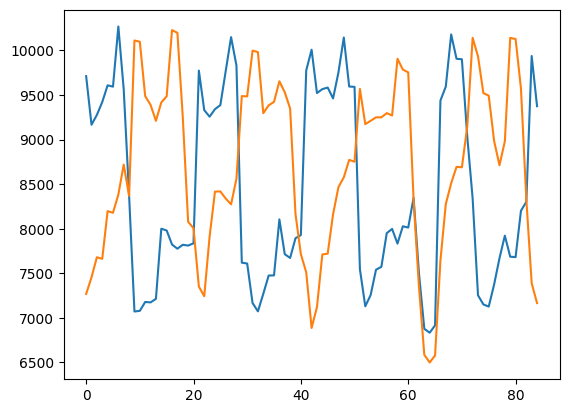

In [280]:

xpoints1 = []
ypoints1 = []
xpoints2 = []
ypoints2 = []

for pose_id in df_test.index:
    gt = np.array(df_test['kpts_cotracker'][pose_id].split(',')).astype(np.float32)
    frame = df_test['image_id'][pose_id] % 100

    neck = get_keypoint(gt,"neck")
    hip = get_keypoint(gt,"right_hip")
    knee = get_keypoint(gt,"right_knee")

    if hip[2] != 0 and knee[2] != 0 and neck[2] != 0:
        angle = getAngle(neck, hip, knee)

        xpoints1.append(frame)
        ypoints1.append(np.degrees(angle))
    
    neck = get_keypoint(gt,"neck")
    hip = get_keypoint(gt,"left_hip")
    knee = get_keypoint(gt,"left_knee")

    if hip[2] != 0 and knee[2] != 0 and neck[2] != 0:
        angle = getAngle(neck, hip, knee)

        xpoints2.append(frame)
        ypoints2.append(np.degrees(angle))

import matplotlib.pyplot as plt
import numpy as np

xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

plt.plot(xpoints1, ypoints1, label = "line 1")
plt.plot(xpoints2, ypoints2, label = "line 2")
plt.show()

Ankle Dorsi/Plantar

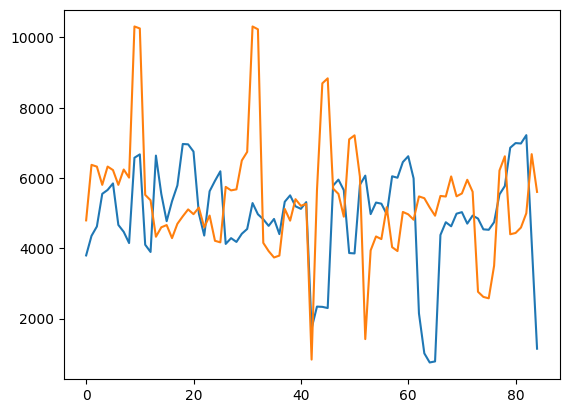

In [282]:

xpoints1 = []
ypoints1 = []
xpoints2 = []
ypoints2 = []

for pose_id in df_test.index:
    gt = np.array(test['kpts_cotracker3'][pose_id].split(',')).astype(np.float32)
    frame = test['image_id'][pose_id] % 100

    heel = get_keypoint(gt,"right_heel")
    ankle = get_keypoint(gt,"right_ankle")
    bigtoe = get_keypoint(gt,"right_big_toe")
    smalltoe = get_keypoint(gt,"right_small_toe")


    if heel[2] != 0 and ankle[2] != 0 and (bigtoe[2] != 0 or smalltoe[2] != 0):
        if bigtoe[2] == 0:
            toe = smalltoe
        elif smalltoe[2] == 0:
            toe = bigtoe
        else:
            toe = (np.array(smalltoe)+np.array(bigtoe))/2

        angle = getAngle(heel, ankle, toe)

        xpoints1.append(frame)
        ypoints1.append(np.degrees(angle))
    
    heel = get_keypoint(gt,"left_heel")
    ankle = get_keypoint(gt,"left_ankle")
    bigtoe = get_keypoint(gt,"left_big_toe")
    smalltoe = get_keypoint(gt,"left_small_toe")

    if heel[2] != 0 and ankle[2] != 0 and (bigtoe[2] != 0 or smalltoe[2] != 0):
        if bigtoe[2] == 0:
            toe = smalltoe
        elif smalltoe[2] == 0:
            toe = bigtoe
        else:
            toe = (np.array(smalltoe)+np.array(bigtoe))/2

        angle = getAngle(heel, ankle, toe)

        xpoints2.append(frame)
        ypoints2.append(np.degrees(angle))

import matplotlib.pyplot as plt
import numpy as np

xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

plt.plot(xpoints1, ypoints1, label = "line 1")
plt.plot(xpoints2, ypoints2, label = "line 2")
plt.show()